<a href="https://colab.research.google.com/github/Aritro30/Scene-Recognition-with-Bag-of-Words/blob/main/CPSC425Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Classifiers.py**

In [ ]:
 #Starter code prepared by Borna Ghotbi for computer vision
 #based on MATLAB code by James Hay

'''This function will predict the category for every test image by finding
the training image with most similar features. Instead of 1 nearest
neighbor, you can vote based on k nearest neighbors which will increase
performance (although you need to pick a reasonable value for k). '''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sn
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.

    Usefull funtion:
    	
    	# You can use knn from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    '''
    #fitting/training the model and predicting labels for the test_image_feats
    neigh = KNeighborsClassifier(n_neighbors = 9)
    neigh.fit(train_image_feats, train_labels)
    predicted_labels = neigh.predict(test_image_feats)
    return predicted_labels



'''This function will train a linear SVM for every category (i.e. one vs all)
and then use the learned linear classifiers to predict the category of
very test image. Every test feature will be evaluated with all 15 SVMs
and the most confident SVM will "win". Confidence, or distance from the
margin, is W*X + B where '*' is the inner product or dot product and W and
B are the learned hyperplane parameters. '''

def svm_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.

    Useful funtion:
    	
    	# You can use svm from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/svm.html

    '''
    #fitting/training the model and predicting labels for the test_image_feats
    ovr = OneVsRestClassifier(LinearSVC(C = 40,random_state=0, max_iter=3000))
    predicted_labels = ovr.fit(train_image_feats, train_labels).predict(test_image_feats)
    return predicted_labels

def plot_matrix(pred_label,test_labels):
  #confusion_matrix(...,...) is called. The created confusion matrix is stored in cm.
  #a function of sklearn. [Approved to be used]  
  cm = confusion_matrix(test_labels, pred_label)
  #the matrix is then labeled horizontally and vertically
  df_cm = pd.DataFrame(cm, index = [map[i] for i in range(15)],
                  columns = [map[i] for i in range(15)])
  #figure is plotted and displayed
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)
  plt.show()  
  #accuracy_score(..,..) is called that gives the accuracy score
  #a function of sklearn. [Approved to be used]
  print(accuracy_score(test_labels, pred_label)*100)

## **Utils.py**

In [ ]:
import matplotlib.pyplot as plt
import random
from random import sample 
import numpy as np
import os
import glob
from sklearn.cluster import KMeans

def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.
    
    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)
    #Since we want to sample tens of thousands of SIFT descriptors from different images, we
    #calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))
    #Initialize an array of features, which will store the sampled descriptors.
    descriptors = np.zeros((n_image * n_each, 128))
    #this array is for convenience of adding the sampled descriptors from each image.
    descriptors_stack = np.zeros((0, 128))
    for i, path in enumerate(image_paths):
        #Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]
        #Randomly sample n_each descriptors from sift_descriptor and store them into descriptors stack
        random_indices = np.random.choice(sift_descriptors.shape[0], n_each, replace=False)
        random_selection = (sift_descriptors[random_indices, :])
        descriptors_stack = np.vstack((descriptors_stack, random_selection))
    #equating descriptors with descriptors_stack
    descriptors = descriptors_stack          
    #perform k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    kmeans = KMeans(n_clusters = vocab_size, random_state=0).fit(descriptors)
    #You can use KMeans from sci-kit learn.
    #Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    return kmeans
    
def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]
    image_feats = np.zeros((n_image, vocab_size))
    #iterating each path in the image_paths numpy array
    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        #checking under which cluster center each feature of the image falls.
        #a numpy array with cluster centroid index number for each feature is returned
        check = kmeans.predict(features[:, 2:])
        #Loop -------------------------------------------------------------------
        #this loop counts the number of features under a certain cluster centroid
        #the count is assigned to the appropriate cell of image_feats array
        sum = 0
        for j in range(vocab_size):
          counter = np.count_nonzero(check == j)
          image_feats[i][j] = counter
          sum += counter
        image_feats[i] = image_feats[i]/sum  
    #the image_feats array is returned
    return image_feats

def create_histogram(image_feats, labels):
  #avg_histogram is a numpy array that contains 15 rows for the 15 classes
  #and total columns that correspond to the number of centroids
  avg_histogram = np.zeros([15, np.shape(image_feats)[1]])
  count = 0
  #functionality of the nested for loop
  #it iterates over each image in image_feats
  #finds its label, sums up the histogram with other images of the same label
  #and puts the sum in the approriate row of the avg_histogram numpy array
  #say for e.g: if the label is 12, the resulting histogram will be placed in avg_histogram[12][:]
  for row in image_feats:
    for j in range(np.shape(avg_histogram)[1]):
      avg_histogram[int(labels[count])][j] += image_feats[count][j]
    count += 1
  count_array = np.zeros(15)
  count = 0
  #this loop will just calculate how many images are there from each class
  for row in image_feats:
    count_array[int(labels[count])] += 1
    count += 1
  #this loop is used to find the average of the histogram by dividing 
  #the sum of histograms of all the images in each class by the total number of images in each class
  #the histograms are also plotted
  count = 0
  for row in avg_histogram:
    avg_histogram[count] /= count_array[count]
    x_scalar = np.arange(np.shape(avg_histogram)[1])
    width = 1.0
    ax = plt.axes()
    plt.xlabel('centroids')
    plt.ylabel('Frequency')
    plt.title(map[count]) 
    plt.bar(x_scalar, avg_histogram[count],color = 'r' )
    plt.show()
    count += 1  
  
    
def load(ds_path):
  """ Load from the training/testing dataset.

  Parameters
  ----------
  ds_path: path to the training/testing dataset.
  e.g., sift/train or sift/test

  Returns
  -------
  image_paths: a (n_sample, 1) array that contains the paths to the descriptors.
  labels: class labels corresponding to each image
  """
  # Grab a list of paths that matches the pathname
  files = sorted(glob.glob(os.path.join(ds_path, "*", "*.txt")))
  n_files = len(files)
  image_paths = np.asarray(files)

  # Get class labels
  classes = sorted(glob.glob(os.path.join(ds_path, "*")))
  labels = np.zeros(n_files)

  for i, path in enumerate(image_paths):
    folder, fn = os.path.split(path)
    labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

  # Randomize the order
  idx = np.random.choice(n_files, size=n_files, replace=False)
  image_paths = image_paths[idx]
  labels = labels[idx]

  return image_paths, labels

## **Main.py**

In [ ]:
#Starter code prepared by Borna Ghotbi, Polina Zablotskaia, and Ariel Shann for Computer Vision
#based on a MATLAB code by James Hays and Sam Birch 

from random import sample 
import numpy as np
#from util import load, build_vocabulary, get_bags_of_sifts
#from classifiers import nearest_neighbor_classify, svm_classify

#For this assignment, you will need to report performance for sift features on two different classifiers:
# 1) Bag of sift features and nearest neighbor classifier
# 2) Bag of sift features and linear SVM classifier

#For simplicity you can define a "num_train_per_cat" vairable, limiting the number of
#examples per category. num_train_per_cat = 100 for intance.

#Sample images from the training/testing dataset. 
#You can limit number of samples by using the n_sample parameter.

print('Getting paths and labels for all train and test data\n')
train_image_paths, train_labels = load("/content/drive/My Drive/hw5/sift/train")
test_image_paths, test_labels = load("/content/drive/My Drive/hw5/sift/test")
#mapping each label represented as integer to its corresponding string label
map = {0: 'Bedroom', 1: 'Coast', 2: 'Forest', 3: 'Highway', 4: 'Industrial', 5: 'InsideCity', 6: 'Kitchen', 7: 'LivingRoom', 8: 'Mountain', 9: 'Office', 10: 'OpenCountry', 11: 'Store', 12: 'Street', 13: 'Suburb', 14: 'TallBuilding'}

Getting paths and labels for all train and test data



In [ ]:
''' Step 1: Represent each image with the appropriate feature
 Each function to construct features should return an N x d matrix, where
 N is the number of paths passed to the function and d is the 
 dimensionality of each image representation. See the starter code for
 each function for more details. '''

        
print('Extracting SIFT features\n')
#TODO: You code build_vocabulary function in util.py
kmeans = build_vocabulary(train_image_paths, vocab_size=200)


Extracting SIFT features



**Saving the results of kmeans in file**

In [ ]:
import pickle
# It is important to use binary access
with open('km.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

**Loading the results of kmeans from file**

In [ ]:
import pickle
with open('km.pickle', 'rb') as f:
    kmeans = pickle.load(f)

**Get bag of SIFTS**

In [ ]:
from numpy import save
from numpy import load
import pandas as pd
#TODO: You code get_bags_of_sifts function in util.py 
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)
#save to npy file
save('train_image_feats.npy', train_image_feats) 
save('test_image_feats.npy', test_image_feats)        

In [ ]:
#load from npy file
train_image_feats = load('train_image_feats.npy')
test_image_feats = load('test_image_feats.npy')


**Average histogram representation**

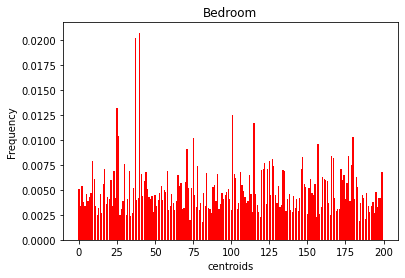

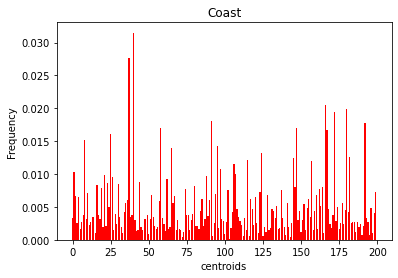

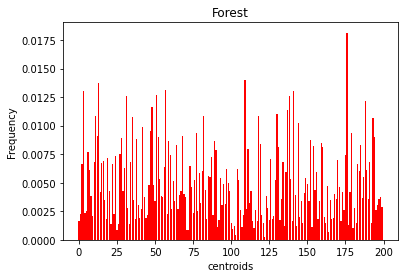

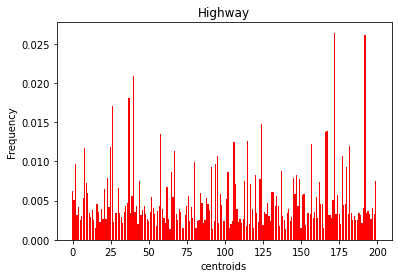

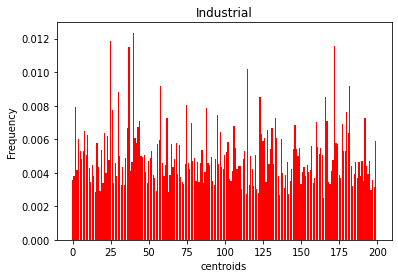

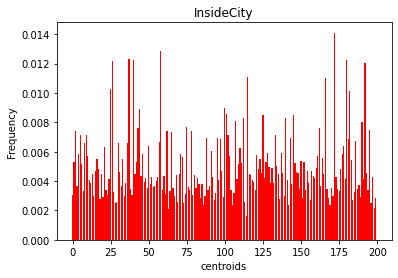

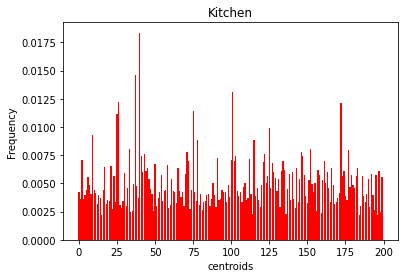

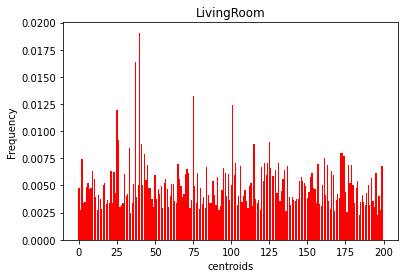

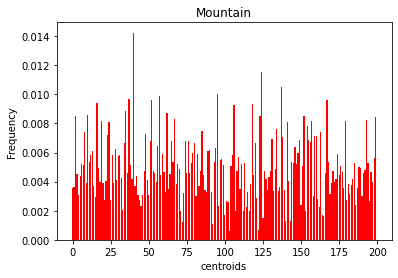

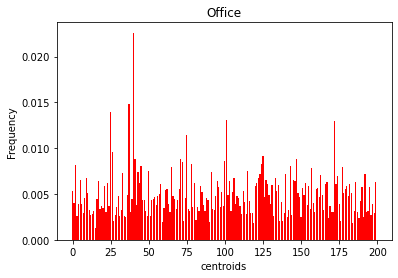

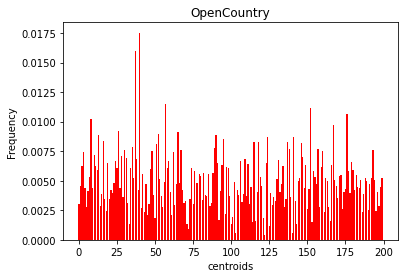

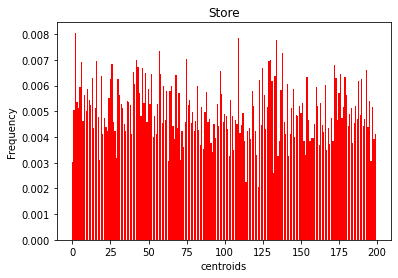

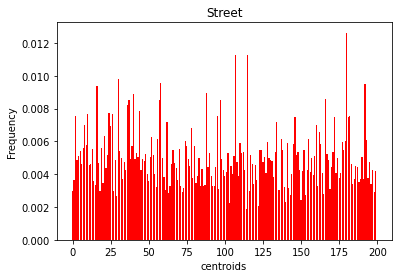

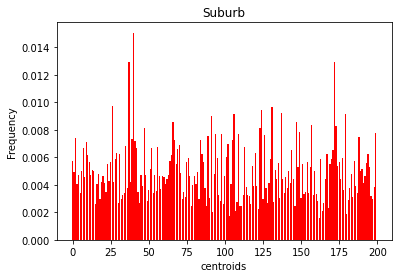

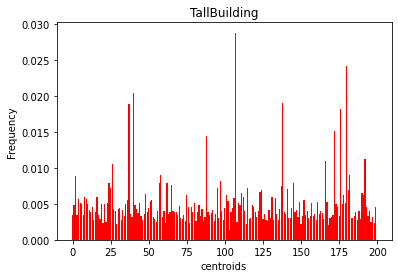

In [ ]:
create_histogram(train_image_feats, train_labels)

**Classes I believe to be hardest to separate are:**

Store, LivingRoom, Kitchen, Suburb etc. If we check the histograms of these classes, we see very less sharp spikes. Their histograms are also very similar to one another. The bars are well distributed for each centroid which tells me that these classes do not have any distintive features. The height of the bars are very much same especially for the class Store. However, classes like Highway, TallBuildings have sharp bars which will be easier to separate. They might have distinct features.

Using nearest neighbor classifier to predict test set categories
----------k = 9
---Evaluation---



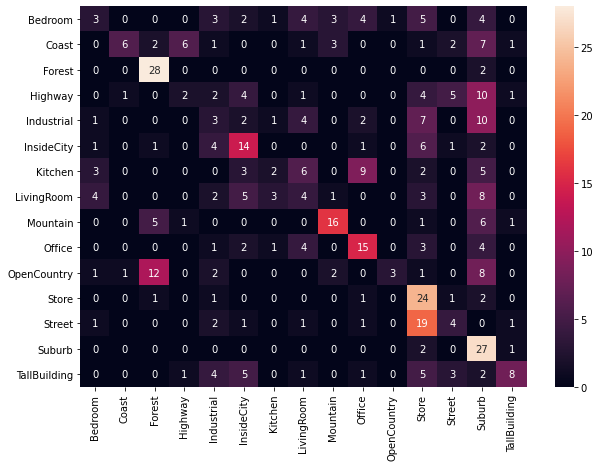

35.333333333333336
Using support vector machine to predict test set categories
----------C = 40
---Evaluation---



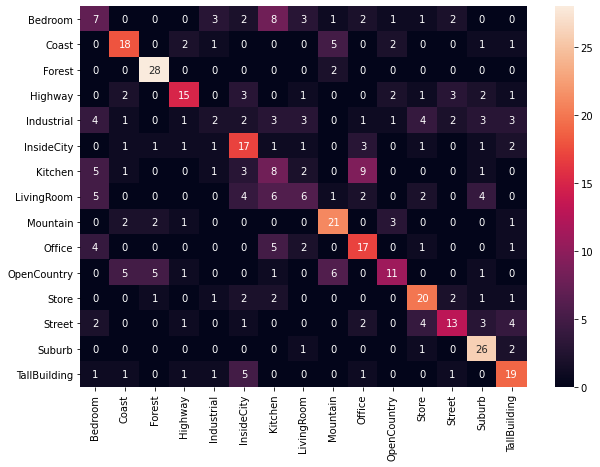

50.66666666666667


In [ ]:
#If you want to avoid recomputing the features while debugging the
#classifiers, you can either 'save' and 'load' the extracted features
#to/from a file.

''' Step 2: Classify each test image by training and using the appropriate classifier
 Each function to classify test features will return an N x l cell array,
 where N is the number of test cases and each entry is a string indicating
 the predicted one-hot vector for each test image. See the starter code for each function
 for more details. '''

print('Using nearest neighbor classifier to predict test set categories\n----------k = 9')
#TODO: YOU CODE nearest_neighbor_classify function from classifers.py
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
print('---Evaluation---\n')
plot_matrix(pred_labels_knn,test_labels)  

print('Using support vector machine to predict test set categories\n----------C = 40')
#TODO: YOU CODE svm_classify function from classifers.py
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)



print('---Evaluation---\n')
plot_matrix(pred_labels_svm,test_labels)
# Step 3: Build a confusion matrix and score the recognition system for 
#         each of the classifiers.
# TODO: In this step you will be doing evaluation. 
# 1) Calculate the total accuracy of your model by counting number
#   of true positives and true negatives over all. 
# 2) Build a Confusion matrix and visualize it. 
#   You will need to convert the one-hot format labels back
#   to their category name format.


# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .10 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .40 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. 
#  accuracy ~= .50 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .60 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.

**kNN performance with different values of k**

I tried a lot of different values of k. When the value of k was 2, the accuracy was 33.33 %. As I increased the value of k, the accuracy increased upto a certain point and then became constant and decreased slightly. When the value of k was 9, I got an accuracy of approximately 35.33%. After that it remained constant and then started decreasing a bit. The values of k that I chose were 2, 5, 7, 9, 13, 17 (Accuracy - 35.33%), 21(Accuracy - 31.78%), 50 (Accuracy - 32.0%). Another thing that I noticed is, with the increase in value of k, the time taken to run the code also increased a bit. Note: A small value of k makes kNN susceptible to noise

**Experimentation with the parameter 'C'**

I have tried different values of C (C=20, C=40, C=60, C=80, C=100, C=120). As the value of C increased, the time taken to run the code also increased significantly. The number of required max iterations also rose. However, the accuracy increased from 50.22% to 50.67% (when C = 40) and then it started decreasing. When C=120, the accuracy was 48.00%.  

In [ ]:
!cp "./drive/My Drive/Colab Notebooks/CPSC425Assignment5.ipynb" ./


In [ ]:
!jupyter nbconvert --to PDF "CPSC425Assignment5.ipynb"

[NbConvertApp] Converting notebook CPSC425Assignment5.ipynb to PDF
[NbConvertApp] Support files will be in CPSC425Assignment5_files/
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425Assignment5_files
[NbConvertApp] Making directory ./CPSC425